In [62]:
# libraries
import matplotlib.pyplot as plt
import numpy as np
from utils import visualize, create_dataset_age, create_dataset, cv
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score, train_test_split
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import warnings

In [63]:
warnings.filterwarnings('ignore')

# ATTEMPT 1: predict age from cortical thickness for all the patients
data = create_dataset_age()
X = data['GlobalCorticalThickness']
y = data['Age']

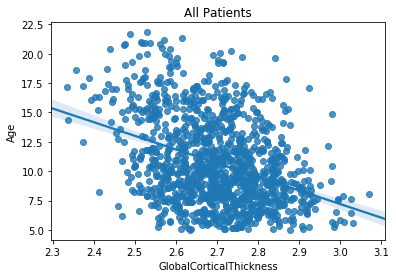

In [64]:
# visualization
visualize()
# I do not see any trend, seems unlikely to work!

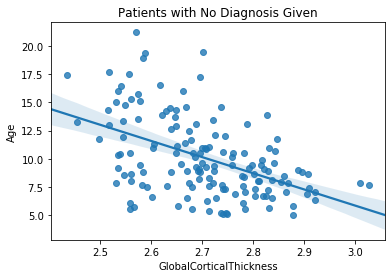

In [65]:
# ATTEMPT 2: predict age from cortical thickness for patients
# with no diagnosis given which we consider to be healthy

data = create_dataset_age(select_disease = 'No Diagnosis Given', select_category = 'DX_01_Cat')
X = data['GlobalCorticalThickness']
y = data['Age']
# visualization
visualize(disease = 'No Diagnosis Given', category = 'DX_01_Cat')


In [66]:
# Baseline for original scale
mean = np.mean(y)
print('mean_age = {}'.format(mean))
baseline_MSE = sum((mean - y)**2)/len(y)
print('baseline_MSE original scale = {}'.format(baseline_MSE))

mean_age = 10.111911486486486
baseline_MSE original scale = 12.187641893472417


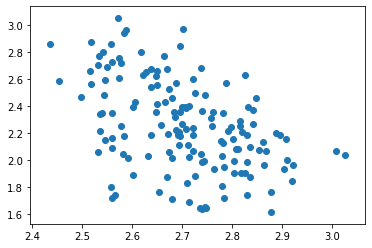

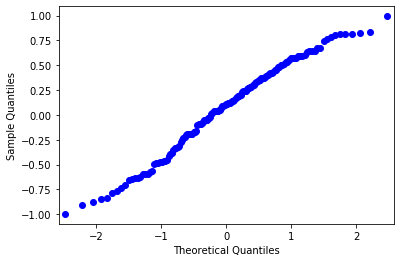

In [67]:
# Check assumptions for linear regression
# convert to numpy arrays
y = np.array(y)
X = np.array(X)

# We try to TRANSFORM THE RESPONSE with logarithm (gives better QQ plot)
y = np.log(y)
plt.scatter(X, y)
plt.show()
# Normally distributed residuals
mod_fit = sm.OLS(X, y).fit()
res = mod_fit.resid
fig = sm.qqplot(res)
plt.show()            # the qq plot shows the assumption of normality roughly holds


In [68]:
# Baseline for log-scale
mean = np.mean(y)
print('mean_age log scale = {}'.format(mean))
baseline_MSE = sum((mean - y)**2)/len(y)
print('baseline_MSE log scale = {}'.format(baseline_MSE))

mean_age log scale = 2.2574735967808164
baseline_MSE log scale = 0.11090023444131321


In [69]:
# split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# reshape
X_train = np.reshape(X_train, [-1, 1])
X_test = np.reshape(X_test, [-1, 1])

# linear regression
regr = LinearRegression().fit(X_train, y_train)
y_pred = regr.predict(X_test)

In [70]:
# estimate test error with CV
lr_cv_res = cv(regr, data=X_train, labels=y_train, n_splits=10)
print(lr_cv_res)
print('\nAverage MSE log scale: {}'.format(np.mean(lr_cv_res)))

# save model parameters
INTERCEPT = regr.intercept_
SLOPE = regr.coef_

[0.12056860359590933, 0.050548459171395596, 0.06520209764691036, 0.13624091635258234, 0.049844407250304854, 0.06868914833716092, 0.07339883444587422, 0.07068937448998167, 0.12274166326876339, 0.06876400882740108]

Average MSE log scale: 0.08266875133862837


In [71]:
# test MSE log-scale
mse_test = sum((y_pred - y_test)**2)/len(y_test)
print('mse_test log scale = {}'.format(mse_test))

mse_test log scale = 0.09981214197407351


In [72]:
# test MSE original scale
mse_test_original = sum((np.exp(y_pred) - np.exp(y_test))**2)/len(y_test)
print('mse_test_original = {}'.format(mse_test_original))

mse_test_original = 10.910139856123525


The MSE in the original scale goes from 12 to 10.9, so the reduction seems tìnot to be relevant.

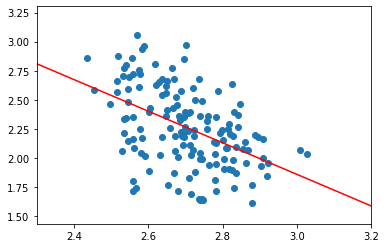

In [73]:
# visualization with response in log-scale
plt.scatter(X, y)
x_ax = np.linspace(2, 3.25,100)
y_ax = INTERCEPT + SLOPE *x_ax
plt.plot(x_ax, y_ax, '-r')
plt.xlim(2.3, 3.2)
plt.show()


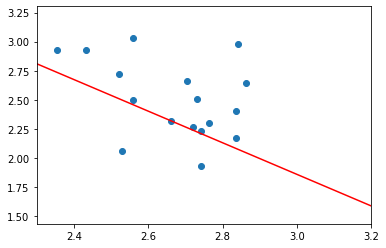

In [74]:
# visualization of linear model for healthy patients over groups of patients with a disease
# Intellectual Disability
with_disease = create_dataset_age(select_disease = 'Intellectual Disability-Mild', select_category = 'DX_01')
X_disease = with_disease['GlobalCorticalThickness']
y_disease = with_disease['Age']
y_disease = np.log(y_disease)
plt.scatter(X_disease, y_disease)
x_ax = np.linspace(2, 3.25,100)
y_ax = INTERCEPT + SLOPE *x_ax
plt.plot(x_ax, y_ax, '-r')
plt.xlim(2.3, 3.2)
plt.show()



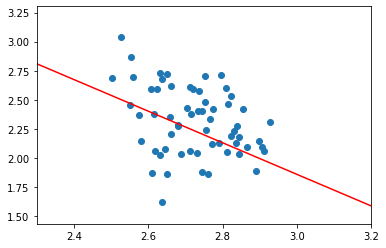

In [75]:

# Specific Learning Disorder with Impairment in Reading
with_disease = create_dataset_age(select_disease = 'Specific Learning Disorder with Impairment in Reading', select_category = 'DX_01')
X_disease = with_disease['GlobalCorticalThickness']
y_disease = with_disease['Age']
y_disease = np.log(y_disease)
plt.scatter(X_disease, y_disease)
x_ax = np.linspace(2, 3.25,100)
y_ax = INTERCEPT + SLOPE *x_ax
plt.plot(x_ax, y_ax, '-r')
plt.xlim(2.3, 3.2)
plt.show()



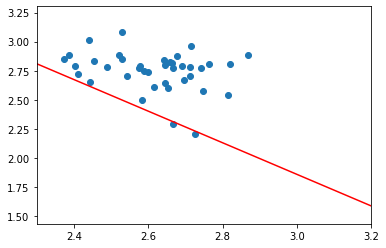

In [76]:
# Major Depressive Disorder
with_disease = create_dataset_age(select_disease = 'Major Depressive Disorder', select_category = 'DX_01')
X_disease = with_disease['GlobalCorticalThickness']
y_disease = with_disease['Age']
y_disease = np.log(y_disease)
plt.scatter(X_disease, y_disease)
x_ax = np.linspace(2, 3.25,100)
y_ax = INTERCEPT + SLOPE *x_ax
plt.plot(x_ax, y_ax, '-r')
plt.xlim(2.3, 3.2)
plt.show()

The reduction in MSE using linear regression is too low (MSE goes from 12 to 10.9), so linear regression on the single variable GlobalCorticalThickness seems not to be enough.
What if we used SVR?

In [79]:
# SVM
svm = SVR(kernel='rbf', C=1, epsilon=0.1)
svm_cv_res = cv(svm, data=X_train, labels=y_train, n_splits=10)
print(svm_cv_res)
print('\nAverage MSE log scale: {}'.format(np.mean(svm_cv_res)))

[0.11733835616866564, 0.04691527576680085, 0.06476010509286143, 0.14155365311518903, 0.050199742813763146, 0.07554715937763007, 0.07838323486634907, 0.07643244796134316, 0.1189794633670371, 0.06111946274326252]

Average MSE log scale: 0.08312289012729021


In [80]:
# test SVR error
pred = svm.predict(X_test)
test_svm_MSE = sum((pred-y_test)**2)/len(y_test)
print('Test MSE log scale: {}'.format(test_svm_MSE))

Test MSE log scale: 0.10211746842770247


Does not improve even with SVR. GlobalCorticalThickness just seems not to be enough.